In [1]:
# Check PyTorch version and GPU availability
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")


Torch version: 2.9.0+cu126
CUDA available: True
Device: cuda


In [2]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Vision utilities (datasets, models, transforms)
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

# Data loading
from torch.utils.data import DataLoader


In [3]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [4]:
# Training data transformations
# - Random flip and crop help the model generalize better
# - Normalize keeps pixel values well-scaled
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    ),
])

# Test data transformations (no randomness)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    ),
])


In [5]:
# Download and load training data
trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

# Download and load test data
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

# Class names (airplane, car, bird, etc.)
classes = trainset.classes
classes


100%|██████████| 170M/170M [00:20<00:00, 8.19MB/s]


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
# Number of images processed at once
batch_size = 128

# Training data loader (shuffled)
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Test data loader (not shuffled)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [7]:
# Create ResNet-18 (not pretrained)
model = resnet18(weights=None)

# Modify first convolution layer for 32x32 images
model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)

# Remove max pooling layer (not needed for CIFAR)
model.maxpool = nn.Identity()

# Change final layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Move model to GPU or CPU
model = model.to(device)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [8]:
# Cross-entropy loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # training mode

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        # Move data to GPU/CPU
        images = images.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Statistics
        total_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [10]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # evaluation mode

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [11]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


In [12]:
epochs = 10

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model, trainloader, optimizer, criterion, device
    )
    test_loss, test_acc = evaluate(
        model, testloader, criterion, device
    )

    # Store values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")


Epoch 01 | Train Loss: 1.3430, Train Acc: 50.94% | Test Loss: 1.2038, Test Acc: 59.73%
Epoch 02 | Train Loss: 0.8745, Train Acc: 68.94% | Test Loss: 1.0457, Test Acc: 66.37%
Epoch 03 | Train Loss: 0.6751, Train Acc: 76.47% | Test Loss: 0.6976, Test Acc: 76.35%
Epoch 04 | Train Loss: 0.5628, Train Acc: 80.40% | Test Loss: 0.6066, Test Acc: 79.95%
Epoch 05 | Train Loss: 0.4908, Train Acc: 82.97% | Test Loss: 0.6099, Test Acc: 80.58%
Epoch 06 | Train Loss: 0.4353, Train Acc: 84.91% | Test Loss: 0.5292, Test Acc: 82.75%
Epoch 07 | Train Loss: 0.3948, Train Acc: 86.39% | Test Loss: 0.5228, Test Acc: 83.56%
Epoch 08 | Train Loss: 0.3564, Train Acc: 87.56% | Test Loss: 0.5001, Test Acc: 83.40%
Epoch 09 | Train Loss: 0.3280, Train Acc: 88.73% | Test Loss: 0.4607, Test Acc: 85.66%
Epoch 10 | Train Loss: 0.2975, Train Acc: 89.63% | Test Loss: 0.4640, Test Acc: 85.05%


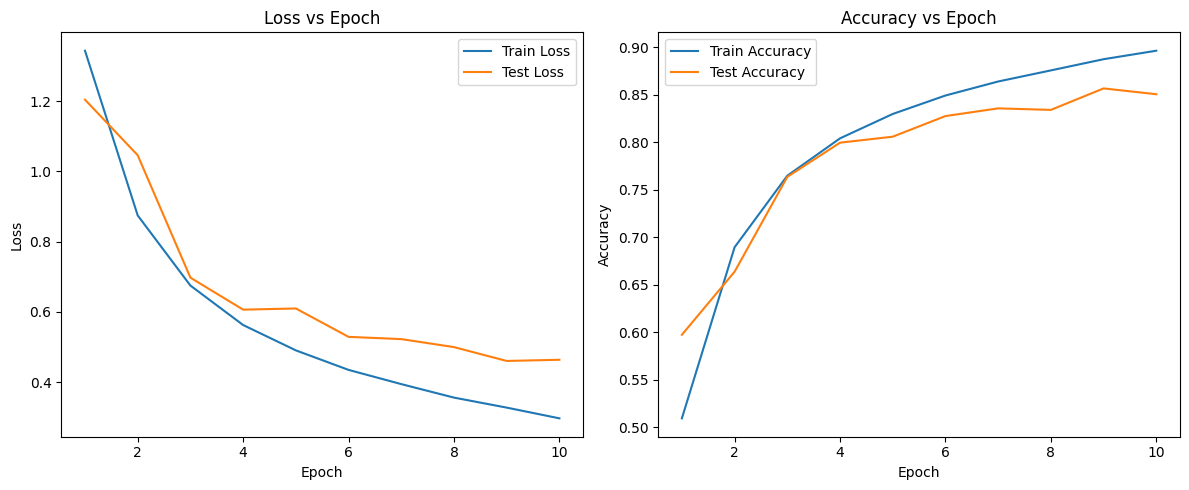

In [13]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()
